In [818]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(4151)

# Part 1

# Problem 1.3

# Compute the number of votes for candidate A given a binomial distribution with n=30 and p=0.55
# Divide votes by 30 for p-hat


successes = np.random.binomial(n=30, p=0.55)
print(f"P-hat = {successes/30}")
print(f"Confidence interval: {0.55-1.96*(0.55*0.45/30)**0.5} <= p <= {0.55+1.96*(0.55*0.45/30)**0.5}")

# Problem 1.5

# Create a factorial function in order to be able to compute the CDF for a binomial distribution

def factorial(n):
    if n == 1 or n==0:
        return 1
    else:
        return n*factorial(n-1)

sum=0

# Store the value of 1000! since it might take a while to compute

# I'm looking for P(X<=500), so I need to take the sum from i = 0 to i = N of (N choose i)*(p^i)*(1-p)^(N-i)
# After I find this value, I take 1-P(X<=500) = P(X>501), which is the probability that the candidate wins
N_factorial = factorial(1000)

for i in range(501):
    sum+=(N_factorial)/(factorial(i)*factorial(1000-i))*(0.55**i)*(0.45**(1000-i))
print(f"Cumulative probability = {1-sum}")

# Problem 1.6

# We sample from a binomial distribution with n=1000 and p=0.55 to find 
p_hat = np.random.binomial(n=1000, p=0.55)/1000
print(f"P-hat = {p_hat}")

for i in range(501):
    sum+=(N_factorial)/(factorial(i)*factorial(1000-i))*(p_hat**i)*((1-p_hat)**(1000-i))
print(f"Cumulative probability of p_hat = {1-sum}")


# Problem 1.7

p_normal_guess = np.random.normal(p_hat, np.sqrt(p_hat*(1-p_hat)/1000)) # Make singular guess by drawing once from the dist
print(f"Initial guess {p_normal_guess}")

sum=0
for i in range(501):
    sum+=(N_factorial)/(factorial(i)*factorial(1000-i))*(p_normal_guess**i)*((1-p_normal_guess)**(1000-i))
print(f"Cumulative probability of single = {1-sum}")
    
p_normal_guesses = np.random.normal(p_hat, np.sqrt(p_hat*(1-p_hat)/1000), size=1000)
avg_p_normal_guesses = np.mean(p_normal_guesses)
print(f"Average of 1000 guesses: {avg_p_normal_guesses}")

sum=0
for i in range(501):
    sum+=(N_factorial)/(factorial(i)*factorial(1000-i))*(avg_p_normal_guesses**i)*((1-avg_p_normal_guesses)**(1000-i))
print(f"Cumulative probability of avg = {1-sum}")                        

# Part 2

# Problem 1

# Generate data as mentioned in the description of problem 2, with nums being the number of data to generate
# Returns the data for Xi and Y
def generate_data(d, nums):
    X1 = np.random.normal(3, 1, size=nums)
    X2 = np.random.normal(-2, 1, size=nums)
    X3 = X1+2*X2
    X4 = (X2+2)**2
    X5 = np.random.binomial(n=1, p=0.8, size=nums)
    remaining_data = [np.random.normal(0,1, size=nums) for x in range(6,d+1)]
    return [np.array([X1, X2, X3, X4, X5, *remaining_data]), np.array(4-3*(X1)**2+X3-0.01*X4+X2*X5+np.random.normal(0,0.1))]

x_train, y_train = generate_data(0, 10000)
x_test, y_test = generate_data(0, 1000)

# We find the training error and testing error for our constant model y = -28.64 using mean squared error

print(np.mean((y_train-10000*[-28.64])**2))
print(np.mean((y_test-1000*[-28.64])**2))

# Now we are going to try to make a decision tree, note that now we need d=10

x_train_v2, y_train_v2 = generate_data(10, 10000)
x_test_v2, y_test_v2 = generate_data(10, 1000)

P-hat = 0.5666666666666667
Confidence interval: 0.3719741591790675 <= p <= 0.7280258408209326
Cumulative probability = 0.9991534507833807
P-hat = 0.547
Cumulative probability = 0.9975555097348988
Initial guess 0.5280769069042289
Cumulative probability of single = 0.9595908395021174
Average of 1000 guesses: 0.5479135229847327
Cumulative probability of avg = 0.998678299852371
310.8567985441914
304.5936348941606


In [839]:
class Node:
    def __init__(self, left=None, right=None, feature=None, alpha=None, is_terminal=False, terminal_value=None):
        self.left = left
        self.right = right
        self.feature = feature
        self.alpha = alpha
        self.is_terminal = is_terminal
        self.terminal_value = terminal_value
        
# We use the tree to hold the collections of nodes

class Tree:
    def __init__(self, stopping_condition, depth=None, sample_size=None):
        self.root = None # We initialize the root to none since we will build the tree in another function
        self.depth = depth # depth to stop at
        self.sample_size = sample_size # sample size to stop at
        self.stopping_condition = stopping_condition # (went unused I think) 0 if we are stopping on depth; 1 if we are stopping on sample_size
        self.features = set()
        
    def generate_tree(self, input, output, current_depth, default): #default helps us deal with weird cases that may arise
        
        if input.shape[1]==0: # fixes some buggy cases where the split was bad
            return Node(is_terminal=True, terminal_value=default)

        if current_depth>self.depth or input.shape[1]<self.sample_size or input.shape[1]==1: # If we are stopping, we add a terminal node
            avg = np.mean(output)
            if avg == None:
                avg = default # If for some reason we mess up with pruning, we set avg = some default variable (for example, the average of y_train_v2)
            return Node(is_terminal=True, terminal_value=avg)
        
        corr = [np.corrcoef(input[x,:], output)[0][1] for x in range(input.shape[0])] # We get the correlation for each Xi and y
        split_input = np.argmax(np.absolute(corr)) # We choose the feature with the highest correlation
        num_alphas = min(int(np.ceil(np.log2(1+input.shape[1]))),input[split_input,:].shape[0]) # We are going to search through a number of alphas that scales logarithmically to reduce the amount of time it takes to make trees.  We also add one to the stuff in the log so we never have a weird case with log(0)
        
        alphas = np.random.choice(np.unique(input[split_input,:]), num_alphas) # We randomly select num_alphas number of alphas and then we look for whichever one reduces the error the most
        best_alpha = 0
        smallest_error = float('inf')

        m = np.mean(output)

        for alpha in alphas:
            left_error = 1/(input[split_input,:]<alpha).shape[0]*np.sum((m-output[input[split_input,:]<alpha])**2) # we find the error for the left branch; "input[split_input,:]<alpha" just tells us to look at indices where split_input < alpha, aka the stuff we want in our left branch
            right_error = 1/(input[split_input,:]>=alpha).shape[0]*np.sum((m-output[input[split_input,:]>=alpha])**2) # we find the error for the right branch
            error = (input[split_input,:]<alpha).shape[0]*left_error/output.shape[0] + (input[split_input,:]>=alpha).shape[0]*right_error/output.shape[0] # We make sure to properly weight the error, as done in the notes, to ensure balanced out cases where a split might be very polarizing (i.e., one large branch, one small branch)
            if error<smallest_error: # compare lowest error before to current error
                best_alpha=alpha # If error < smallest_error, we've found our new best alpha, since this does a better job minimizing the error
            error=min(smallest_error,error)
        left_input = input[:,input[split_input,:]<best_alpha] # The input for the left is now everything that had X_split < alpha
        right_input = input[:,input[split_input,:]>=best_alpha] # Vice versa for the right
        left_output = output[input[split_input,:]<best_alpha] # The output for the left is now everything that corresponds to when X_spit < alpha
        right_output = output[input[split_input,:]>=best_alpha] # Vice versa for the right            
        
        # We recursively construct the tree on the left and right
        
        left_tree = self.generate_tree(left_input, left_output, current_depth+1, default) 
        right_tree = self.generate_tree(right_input, right_output, current_depth+1, default)
        self.features.add(split_input)
        return Node(left=left_tree, right=right_tree, feature=split_input, alpha=best_alpha)
        
    def predict(self, input): # Basically, we keep going down to our tree until we reach a terminal node.  Then, we return its value
        curr = self.root
        while curr.terminal_value==None:
            if input[curr.feature] < curr.alpha:
                curr = curr.left
            else:
                curr = curr.right
        return curr.terminal_value

    def predict_on_test(self, input): # We predict over the entire test set by calling the predict metho
        return np.array([self.predict(input[:,x]) for x in range(input.shape[1])])

In [840]:
# Problem 2

# We will now generate several trees using depth as stopping condition and varying the depth value:
depth_trees = []
for i in range(1, 20):
    depth_trees.append(Tree(0, depth=i,sample_size=1)) # Initialize sample size really low so we're very unlikely to stop on it
for tree in depth_trees:
    tree.root = tree.generate_tree(x_train_v2, y_train_v2, 0, np.mean(y_train_v2)) # build the trees and initialize root

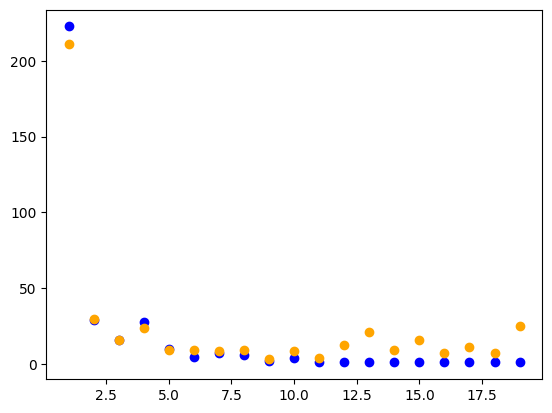

In [846]:
depth_mse_train = np.mean(np.array([(x.predict_on_test(x_train_v2) - y_train_v2)**2 for x in depth_trees]),axis=1) # Record the mean squared error of our model evaluated on the training set
depth_mse_test = np.mean(np.array([(x.predict_on_test(x_test_v2) - y_test_v2)**2 for x in depth_trees]),axis=1) # Record the mean squared error of our model evaluated on the test set

plt.scatter([x for x in range(1,20)], depth_mse_train, color = 'blue') # x-axis represents the depth; y-axis represents the mse on the training data
plt.scatter([x for x in range(1,20)], depth_mse_test, color = 'orange') # x-axis represents the depth; y-axis represents the mse on the test data
plt.show()

In [842]:
# We will now generate several trees using sample size as stopping condition and varying the depth value
sample_size_trees = []
for i in range(20,100,5):
    sample_size_trees.append(Tree(1, depth=100, sample_size=i)) # Initialize depth really high so we're very unlikely to stop on it
for tree in sample_size_trees:
    tree.root = tree.generate_tree(x_train_v2, y_train_v2, 0, np.mean(y_train_v2))

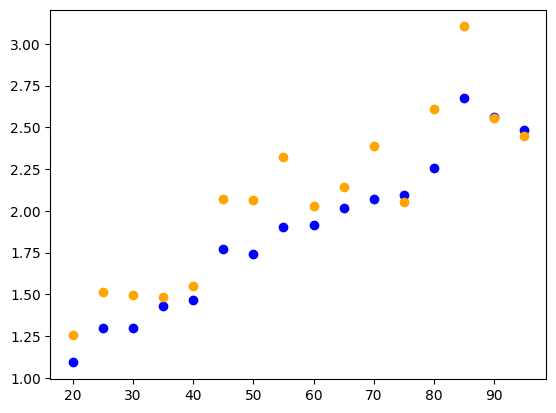

In [845]:
sample_size_mse_train = np.mean(np.array([(x.predict_on_test(x_train_v2) - y_train_v2)**2 for x in sample_size_trees]),axis=1) # Record the mean squared error of our model evaluated on the training set
sample_size_mse_test = np.mean(np.array([(x.predict_on_test(x_test_v2) - y_test_v2)**2 for x in sample_size_trees]),axis=1) # Record the mean squared error of our model evaluated on the test set

plt.scatter(range(20,100,5), sample_size_mse_train, color = 'blue') # x-axis represents the depth; y-axis represents the mse on the training data
plt.scatter(range(20,100,5), sample_size_mse_test, color = 'orange') # x-axis represents the depth; y-axis represents the mse on the test data
plt.show()

In [850]:
#Problem 3
# Now we set d=50 and do the same thing.

x_train_v3, y_train_v3 = generate_data(50, 10000) # we generate the training and testing data for d=50
x_test_v3, y_test_v3 = generate_data(50, 1000)

# We will now generate several trees using depth as stopping condition and varying the depth value:
depth_trees_v2 = []
for i in range(1, 20):
    depth_trees_v2.append(Tree(0, depth=i, sample_size=1)) # Initialize sample_size really low so we're very unlikely to stop on it
for tree in depth_trees_v2: # build the trees and initialize root
    tree.root = tree.generate_tree(x_train_v3, y_train_v3, 0, np.mean(y_train_v3))

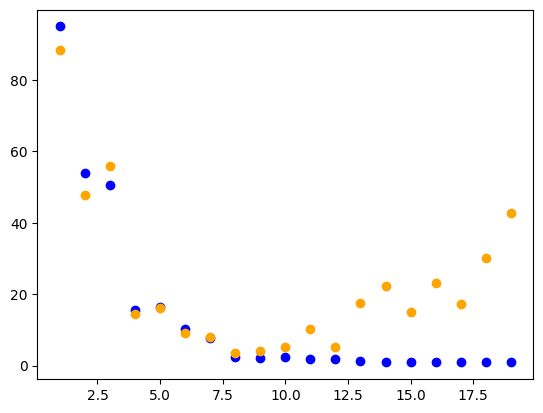

In [854]:
depth_mse_train_v2 = np.mean(np.array([(x.predict_on_test(x_train_v3) - y_train_v3)**2 for x in depth_trees_v2]),axis=1) # Record the mean squared error of our model evaluated on the training set
depth_mse_test_v2 = np.mean(np.array([(x.predict_on_test(x_test_v3) - y_test_v3)**2 for x in depth_trees_v2]),axis=1) # Record the mean squared error of our model evaluated on the test set
plt.scatter(range(1,20), depth_mse_train_v2, color='blue') # x-axis represents the depth; y-axis represents the mse on the training data
plt.scatter(range(1,20), depth_mse_test_v2, color='orange')
plt.show()

In [855]:
# We will now generate several trees using sample size as stopping condition and varying the depth value
sample_size_trees_v2 = []
for i in range(20,100,5):
    sample_size_trees_v2.append(Tree(0, depth=100, sample_size=i)) # Initialize depth really high so we're very unlikely to stop on it
for tree in sample_size_trees_v2:
    tree.root = tree.generate_tree(x_train_v3, y_train_v3, 0, np.mean(y_train_v2))

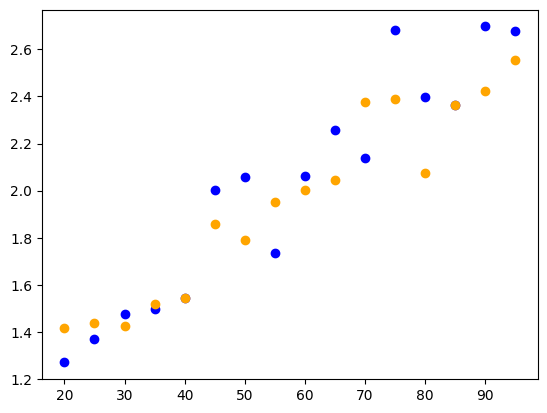

In [857]:
sample_size_mse_train_v2 = np.mean(np.array([(x.predict_on_test(x_train_v3) - y_train_v3)**2 for x in sample_size_trees_v2]),axis=1)
sample_size_mse_test_v2 = np.mean(np.array([(x.predict_on_test(x_test_v3) - y_test_v3)**2 for x in sample_size_trees_v2]),axis=1)
plt.scatter(range(20,100,5), sample_size_mse_train_v2, color='blue') # x-axis represents the depth; y-axis represents the mse on the test data
plt.scatter(range(20,100,5), sample_size_mse_test_v2, color='orange') # x-axis represents the depth; y-axis represents the mse on the test data

plt.show()

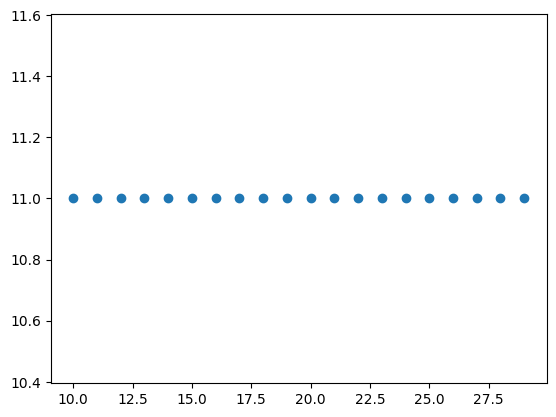

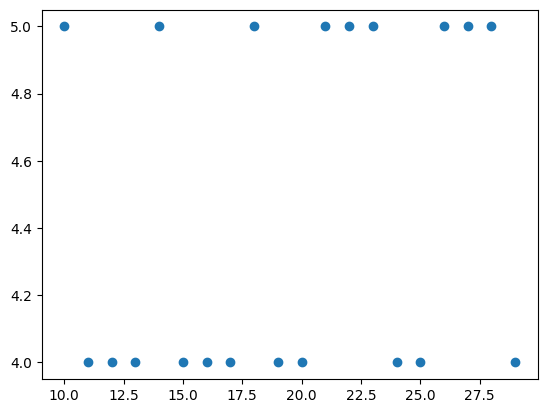

In [817]:
# Now we generate data with varying values for d, and we compare the superfluous variables in depth and sample size trees
data = []
for i in range(20):
    data.append(generate_data(d, 10000))
depth_trees_v3=[Tree(0, depth=20, sample_size=1) for x in range(20)]
sample_size_trees_v3=[Tree(0, depth=100, sample_size=30) for x in range(20)]
for d in range(len(depth_trees_v3)):
    depth_trees_v3[d].root = depth_trees_v3[d].generate_tree(data[d][0],data[d][1],0,np.mean(data[d][0])) # intialize all depth trees
    sample_size_trees_v3[d].root = sample_size_trees_v3[d].generate_tree(data[d][0],data[d][1],0,np.mean(data[d][0])) # initialize all sample size trees
plt.scatter([range(10,30)], [len(x.features) for x in depth_trees_v3]) # x-axis represents d, y-axis represents number of features used
plt.show()
plt.scatter(range(10,30), [len(x.features) for x in sample_size_trees_v3])
plt.show()

In [822]:
# Now we make a linear regression model by directly solving for w*, using the equation in the notes.
# Note that the way we made our x_train_v2 matrix, it is the transpose of what we called X in class.
# Thus, whenever we would take the transpose of X in the equation from class, we don't here, and vice versa
XTX = np.matmul(x_train_v2, x_train_v2.T)
XTX_inv = np.linalg.inv(XTX)
XTX_inv_XT = np.matmul(XTX_inv, x_train_v2)
w_optimal = np.matmul(XTX_inv_XT, y_train_v2.reshape(10000,1)) # Need to reshape to the multiplication works

(10, 10000)
(10000,)


In [832]:
# Now we find the mean squared error for our linear model
print(w_optimal)
linear_mse_train = np.mean((np.matmul(x_train_v2.T, w_optimal) - y_train_v2)**2)
linear_mse_test = np.mean((np.matmul(x_test_v2.T, w_optimal) - y_test_v2)**2)
print(linear_mse_train)
print(linear_mse_test)

[[-7.57077650e+01]
 [-1.06213377e+02]
 [ 3.31343735e+01]
 [ 7.98571911e-01]
 [ 5.91237787e+00]
 [ 1.82881557e-01]
 [-8.88326757e-02]
 [ 6.76128518e-02]
 [-1.03998460e-01]
 [-4.79075390e-02]]
3930.1977175268303
3789.7109714835697
[-7.57077650e+01 -1.06213377e+02  3.31343735e+01  7.98571911e-01
  5.91237787e+00  1.82881557e-01 -8.88326757e-02  6.76128518e-02
 -1.03998460e-01 -4.79075390e-02]


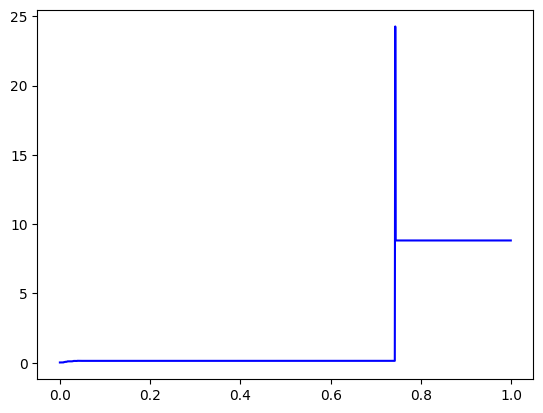

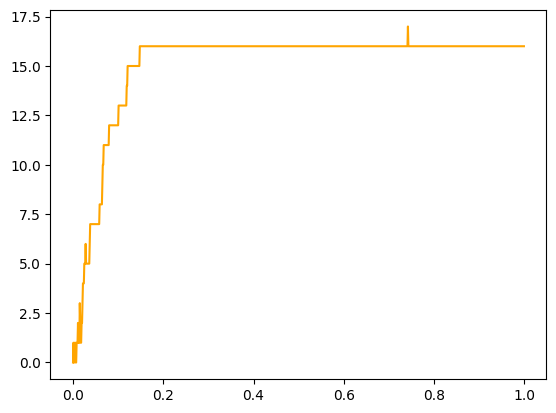

In [824]:
# Now we go back to using d=50
# Also, we have some parameter epsilon such that if |wi| <= epsilon, we set wi = 0 so that the feature is ignored
inputs = [x/1000 for x in range(0, 1000)] # This represents the possible epsilon values

def get_optimal_weights(x, y):
    return np.matmul(np.matmul(np.linalg.inv(np.matmul(x, x.T)),x),y)

linear_mse_test_v2 = []
num_superfluous = []
mask = np.ones(50,dtype=int)
for i in inputs:
    superfluous = 0
    mod_x_train = x_train_v3[mask==1,:] # We need to sift out the features which we are supposed to ignore which we do with this mask
    mod_x_test = x_test_v3[mask==1,:]
    opt_w = get_optimal_weights(mod_x_train, y_train_v3)
    for j in range(len(opt_w)):
        if abs(opt_w[j])<=i: #If we encounter a weight less than epsilon, increment superfluous and adjust the mask array
            superfluous+=1
            mask[j]=0
    linear_mse_test_v2.append(np.mean(np.matmul(mod_x_test.T, opt_w)-y_test_v3)**2) # We compute mse
    num_superfluous.append(superfluous)
plt.plot(inputs, linear_mse_test_v2, color="Blue") # Plots mse for each model (y-axis) vs epsilon values (x-axis)
plt.show()
plt.plot(inputs, num_superfluous, color="Orange") # Plots number of superfluous features (y-axis) vs epsilon values (x-axis)
plt.show()